In [238]:
import pandas as pd
import matplotlib.pyplot as plt

Data Loading & Filtering

    -data is loaded from the csv file

In [239]:
file ="data.csv"

data = pd.read_csv(file, delimiter=',')

print(data.columns)

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')


    -removed unnecessary columns & renamed them in english

In [240]:
data = data[['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']]

data.columns = ['Category', 'Type', 'Year', 'Month', 'Value']
print(data.head(4))

         Category       Type  Year   Month  Value
0  Alkoholunfälle  insgesamt  2024  202401    NaN
1  Alkoholunfälle  insgesamt  2024  202402    NaN
2  Alkoholunfälle  insgesamt  2024  202403    NaN
3  Alkoholunfälle  insgesamt  2024  202404    NaN


    -removed all entries with year > 2020 & formatted the month column

In [241]:
data = data[(data['Year'] <= 2020) & (data['Month'] != "Summe") & (data['Type'] == "insgesamt")]
print(data.head(4))

          Category       Type  Year   Month  Value
51  Alkoholunfälle  insgesamt  2020  202001   28.0
52  Alkoholunfälle  insgesamt  2020  202002   40.0
53  Alkoholunfälle  insgesamt  2020  202003   27.0
54  Alkoholunfälle  insgesamt  2020  202004   26.0


In [242]:
data =data.sort_values(by=['Month'])

data['Month'] = data['Month'].str[4:]
print(data.head(4))

             Category       Type  Year Month   Value
310    Alkoholunfälle  insgesamt  2000    01    78.0
954     Fluchtunfälle  insgesamt  2000    01   835.0
1598  Verkehrsunfälle  insgesamt  2000    01  3448.0
311    Alkoholunfälle  insgesamt  2000    02    53.0


In [243]:
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str),
        format='%Y-%m')

In [244]:
print(data['Category'].unique())

['Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle']


In [245]:
data = data[data['Category'] == "Alkoholunfälle"]

Data Visualization

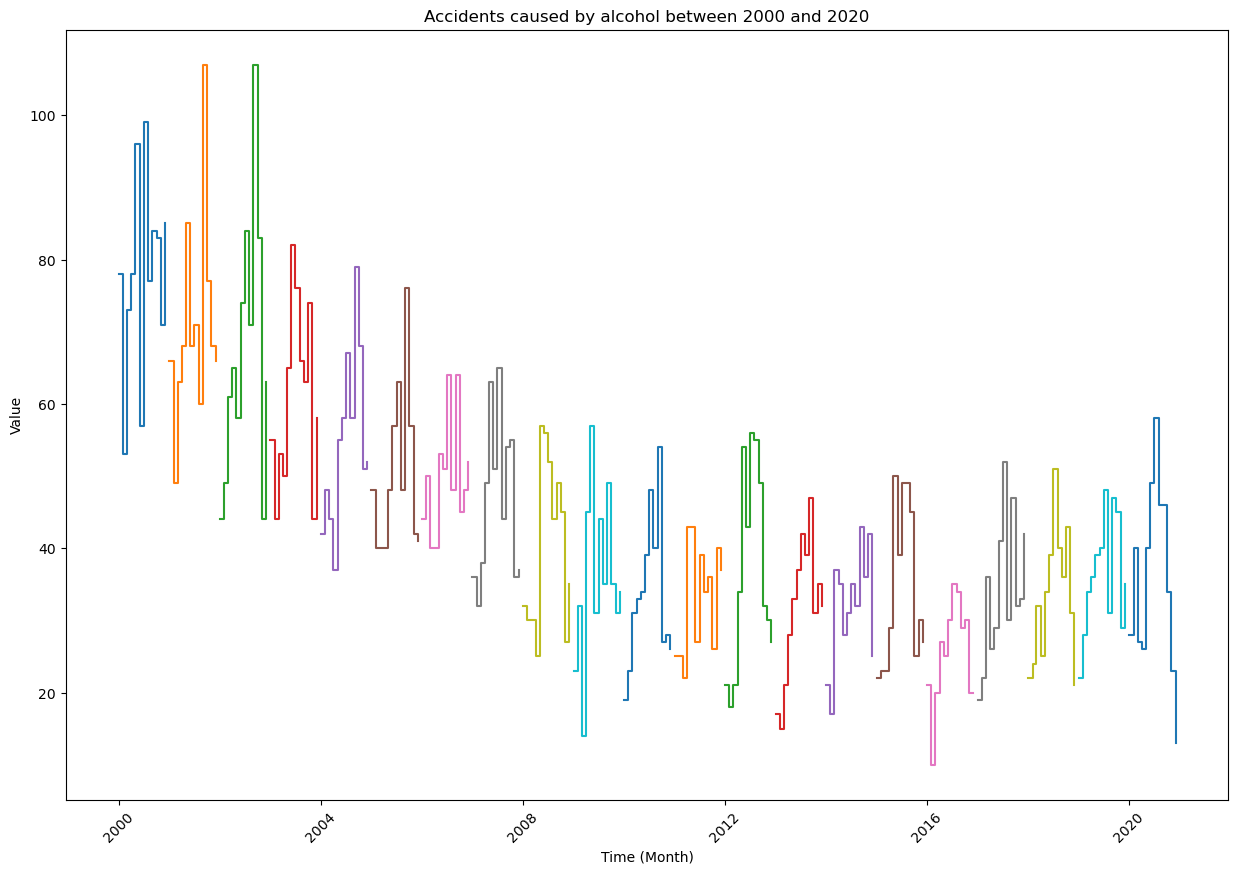

In [246]:
plt.figure(figsize=(15, 10))
for year in data['Year'].unique():
    year_data = data[data['Year'] == year]
    plt.step(
        year_data['Date'],
        year_data['Value'],
        label=str(year),
        where='post'
    )
plt.xticks(rotation=45)
plt.title('Accidents caused by alcohol between 2000 and 2020')
plt.xlabel('Time (Month)')
plt.ylabel('Value')
plt.show()

Split data into training and testing sets

In [247]:
index = int(len(data) * 0.8)

training_set = data[:index]
test_set = data[index:]

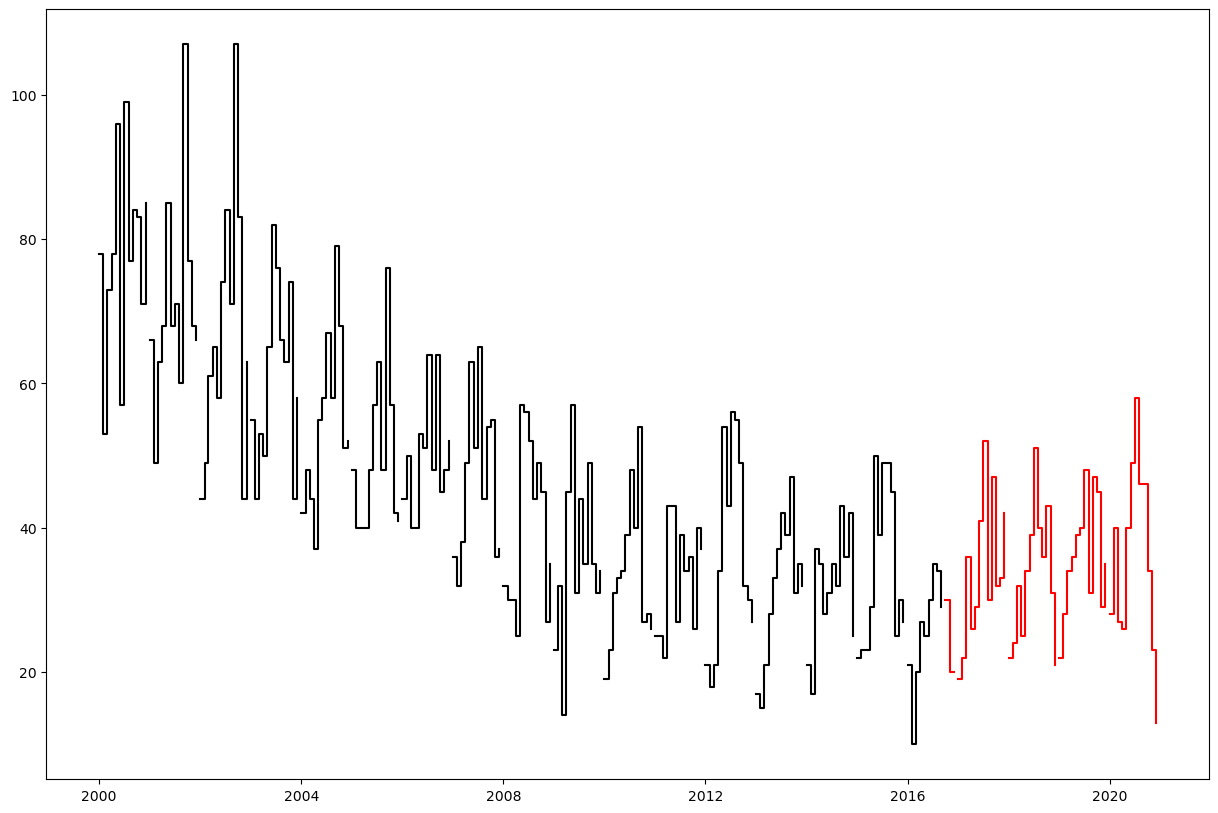

In [248]:
plt.figure(figsize=(15, 10))
for year in training_set['Year'].unique():    
    year_data = training_set[training_set['Year'] == year]
    plt.step(
        year_data['Date'],
        year_data['Value'],
        label=str(year),
        where='post',
        color = "black"
    )

for year in test_set['Year'].unique():    
    year_data = test_set[test_set['Year'] == year]
    plt.step(
        year_data['Date'],
        year_data['Value'],
        label=str(year),
        where='post',
        color = "red"
    )
plt.show()


Import SARIMAX model

In [249]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Train the model

In [250]:
training_set.set_index('Date', inplace=True)
input_data = training_set['Value'].asfreq('MS')

#define the model
ARMAmodel = SARIMAX(input_data, order = (1, 0, 1))

#fit the model
ARMAmodel_fit = ARMAmodel.fit()

Get forecast

In [251]:
forecast_date = pd.date_range(start='2021-01-01', end='2021-01-31', freq='MS')

# Forecast for 2021-01-01
forecast = ARMAmodel_fit.forecast(steps=1, index=forecast_date)
print(forecast)

2021-01-01    30.285145
Freq: MS, dtype: float64


Plot forecast


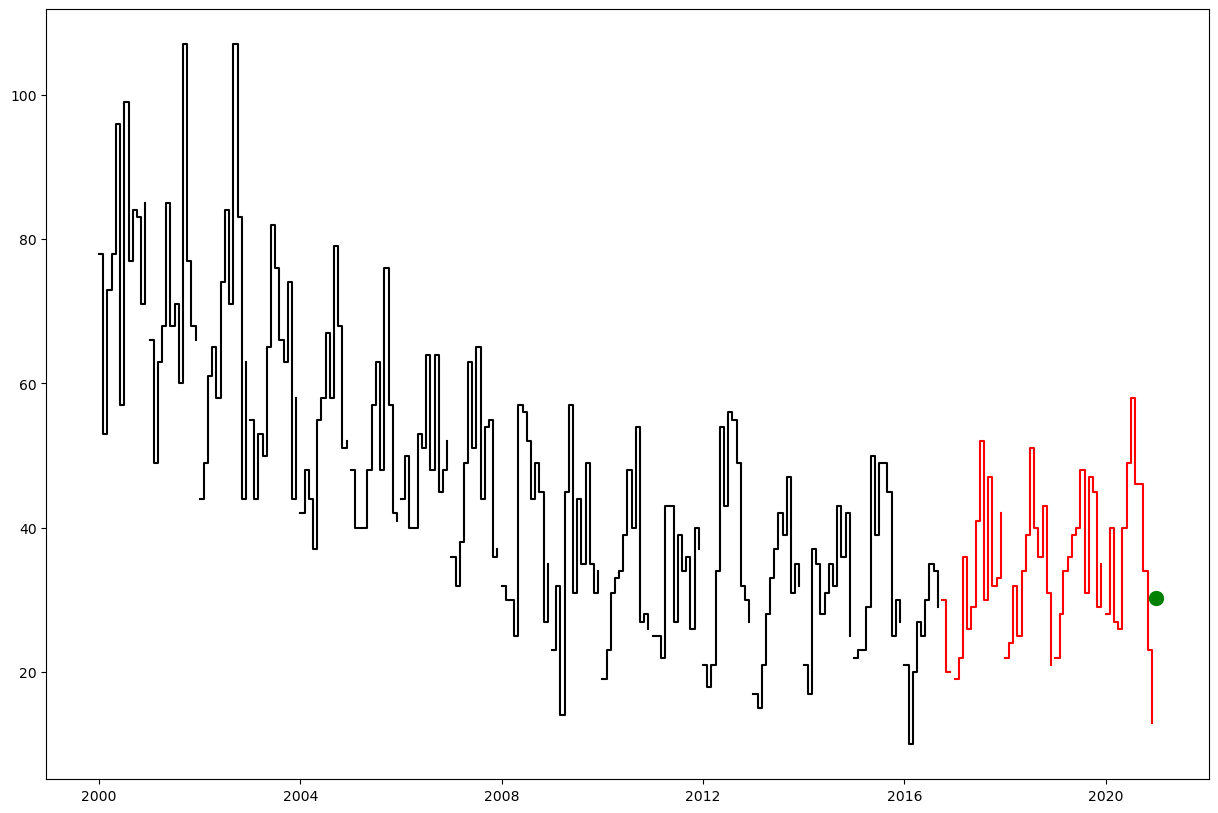

In [252]:
plt.figure(figsize=(15, 10))
for year in training_set['Year'].unique():    
    year_data = training_set[training_set['Year'] == year]
    plt.step(
        year_data.index,
        year_data['Value'],
        label=str(year),
        where='post',
        color = "black"
    )

for year in test_set['Year'].unique():    
    year_data = test_set[test_set['Year'] == year]
    plt.step(
        year_data['Date'],
        year_data['Value'],
        label=str(year),
        where='post',
        color = "red"
    )

# Add forecast point
plt.plot(forecast, 
         'go',  # green dot
         markersize=10,
         label='Forecast Jan 2021')

plt.show()


Inspiration: https://builtin.com/data-science/time-series-forecasting-python